# autoencoder를 활용하여 Fashion MNIST Dataset의 Denosing 실험

In [61]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [110]:
def load_dataset(batch_size=64, is_train=True):
    # For Debugging
    torch.manual_seed(42)
    noise_set = datasets.FashionMNIST(
        root      = './dataset',
        train     = True,
        download  = True,
        transform = transforms.Compose([
            transforms.ToTensor(),
        ])
    )

    _noise_loader = DataLoader(
        dataset     = noise_set,
        batch_size  = batch_size,
        shuffle     = True,
        num_workers = 2
    )

    return _noise_loader

data_loader = load_dataset()

## 모델 정의

In [111]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 10),   # 입력의 특징을 3차원으로 압축합니다
        )
        self.decoder = nn.Sequential(
            nn.Linear(10, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),       # 픽셀당 0과 1 사이로 값을 출력합니다
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

## 모델 학습

In [121]:
import torch.optim as optim
import torch.nn as nn
import time
import copy

In [122]:
def AddGaussianNoise(tensor, std=0.1, mean=0):
    return tensor + torch.randn(tensor.size()) * std + mean

In [123]:
NUM_OF_EPOCH = 20

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Autoencoder()
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=0.005) # 기울기 업데이트 -> how to?
criterion = nn.MSELoss()# y_hat과 y의 차이를 구함

best_model_weights = copy.deepcopy(model.state_dict())
best_loss = float("inf")

In [124]:
for epoch in range(NUM_OF_EPOCH):
    model.train()

    running_loss = 0.0

    for image, _ in data_loader:
        inputs = AddGaussianNoise(image).view(-1, 28*28).to(device)
        answer = image.view(-1, 28*28).to(device)
        optimizer.zero_grad() # 이전에 구했던 기울기를 0으로 초기화 함

        outputs = model(inputs) # 네트워크를 통과시킴 => computational graph가 만들어짐
        loss = criterion(outputs, answer)

        # back-propagation
        loss.backward()
        optimizer.step()

        running_loss += float(loss.item() * inputs.size(0))

    epoch_loss = running_loss / len(data_loader.dataset)

    print('Epoch {}/{}: {} Loss: {:.4f}'.format(epoch + 1, NUM_OF_EPOCH,"train", epoch_loss))

    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model_weights = copy.deepcopy(model.state_dict())

Epoch 1/20: train Loss: 0.0340
Epoch 2/20: train Loss: 0.0227
Epoch 3/20: train Loss: 0.0209
Epoch 4/20: train Loss: 0.0197
Epoch 5/20: train Loss: 0.0187
Epoch 6/20: train Loss: 0.0180
Epoch 7/20: train Loss: 0.0173
Epoch 8/20: train Loss: 0.0169
Epoch 9/20: train Loss: 0.0167
Epoch 10/20: train Loss: 0.0166
Epoch 11/20: train Loss: 0.0164
Epoch 12/20: train Loss: 0.0163
Epoch 13/20: train Loss: 0.0162
Epoch 14/20: train Loss: 0.0161
Epoch 15/20: train Loss: 0.0161
Epoch 16/20: train Loss: 0.0159
Epoch 17/20: train Loss: 0.0158
Epoch 18/20: train Loss: 0.0157
Epoch 19/20: train Loss: 0.0157
Epoch 20/20: train Loss: 0.0155


In [125]:
# save model weight
torch.save(best_model_weights, './weights/best_weights.pth')

### 학습이 잘 되었는지 시각화

In [126]:
import matplotlib.pyplot as plt

In [129]:
# testing
with torch.no_grad():
    test_data = data_loader.dataset[0][0].view(-1, 28*28)
    test_noise = AddGaussianNoise(test_data).to(device)
    test_output = model(test_noise)


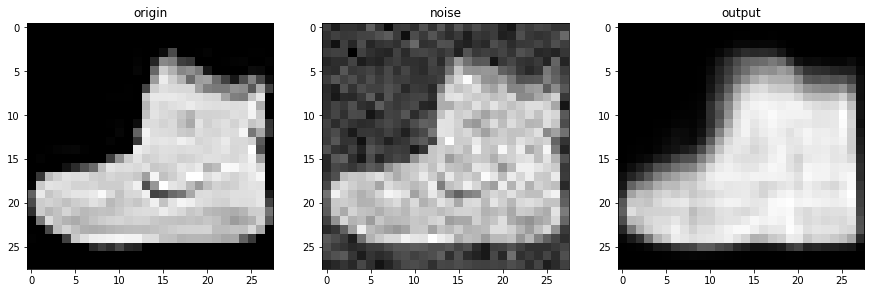

In [131]:
# 시각화
test_data = test_data.view(28,28).to("cpu")
test_noise = test_noise.view(28,28).to("cpu")
test_output = test_output.view(28,28).to("cpu")

f, a = plt.subplots(1, 3, figsize=(15, 15))
a[0].set_title('origin')
a[1].set_title('noise')
a[2].set_title('output')
a[0].imshow(test_data, cmap='gray')
a[1].imshow(test_noise, cmap='gray')
a[2].imshow(test_output.detach(), cmap='gray')